In [35]:
import pandas as pd
import os
import sys
import statsmodels
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.decomposition import PCA
from pathlib import Path

# Configuração visual
sns.set_style("ticks")
plt.rcParams['figure.figsize'] = (10, 6)

In [36]:
# =============================================================================
# CARREGAMENTO E DADOS
# =============================================================================
PROJETO_ROOT = Path.cwd().parent  # sobe de notebooks/ para HW2/


# adicionar src/ ao sys.path 
SRC_PATH = PROJETO_ROOT / "src"
if SRC_PATH.exists():
    sys.path.append(str(SRC_PATH))
    print(f"src/ adicionado ao path: {SRC_PATH}")

# carregar os dados da pasta solubility
DADOS_PATH = PROJETO_ROOT / "solubility"

# verificando se os arquivos existem
arquivos_esperados = ["solTrainX.txt", "solTrainY.txt", "solTestX.txt", "solTestY.txt"]
for arquivo in arquivos_esperados:
    caminho = DADOS_PATH / arquivo
    if caminho.exists():
        print(f"{arquivo} encontrado")
    else:
        print(f"{arquivo} NÃO encontrado em {caminho}")

# carregando por fim
X_train_raw = pd.read_csv(DADOS_PATH / "solTrainX.txt", sep='\t')
y_train = pd.read_csv(DADOS_PATH / "solTrainY.txt", sep='\t').values.ravel()
X_test_raw  = pd.read_csv(DADOS_PATH / "solTestX.txt", sep='\t')
y_test  = pd.read_csv(DADOS_PATH / "solTestY.txt", sep='\t').values.ravel()

print(f"\nDados carregados com sucesso!")
print(f"X_train: {X_train_raw.shape}, X_test: {X_test_raw.shape}")

# Separar Binárias e Contínuas
cols_binarias = [col for col in X_train_raw.columns if X_train_raw[col].nunique() <= 2]
cols_continuas = [col for col in X_train_raw.columns if col not in cols_binarias]

src/ adicionado ao path: /home/natan/Área de trabalho/HW2/src
solTrainX.txt encontrado
solTrainY.txt encontrado
solTestX.txt encontrado
solTestY.txt encontrado

Dados carregados com sucesso!
X_train: (951, 228), X_test: (316, 228)


In [37]:
# =============================================================================
# EDA: VISUALIZAÇÃO INICIAL DOS DADOS
# =============================================================================

print("\n>>> ANÁLISE DE VARIÁVEIS E ESTATÍSTICAS DESCRITIVAS...")

# 1. Exibir tipos de variáveis (binárias)
print(f"\nNúmero de variáveis binárias: {len(cols_binarias)}")
if len(cols_binarias) > 0:
    print(f"Variáveis binárias: {cols_binarias}")

# 2. Exibir tipos de variáveis (contínuas)
print(f"\nNúmero de variáveis contínuas: {len(cols_continuas)}")
if len(cols_continuas) > 0:
    print(f"Variáveis contínuas: {cols_continuas}")

# 3. Gerar tabela de estatísticas descritivas para variáveis contínuas
print("\nEstatísticas Descritivas para Variáveis Contínuas (X_train_raw):\n")
descriptive_stats = X_train_raw[cols_continuas].describe()
print(descriptive_stats.to_markdown(numalign="left", stralign="left"))

print("\n>>> ANALISANDO SKEWNESS DAS VARIÁVEIS CONTÍNUAS...")

# 1. Calcular o skewness (assimetria) de todas as variáveis contínuas em X_train_raw
skewness_values = X_train_raw[cols_continuas].skew()

# 2. Ordenar os valores de skewness
skewness_sorted = skewness_values.sort_values(ascending=False)

print("Skewness calculado para variáveis contínuas.")

print("\nTop 5 Variáveis Contínuas com Maior Skewness Positivo:")
print(skewness_sorted.head(5).to_markdown(numalign="left", stralign="left"))

print("\nTop 5 Variáveis Contínuas com Maior Skewness Negativo:")
print(skewness_sorted.tail(5).to_markdown(numalign="left", stralign="left"))


>>> ANÁLISE DE VARIÁVEIS E ESTATÍSTICAS DESCRITIVAS...

Número de variáveis binárias: 208
Variáveis binárias: ['FP001', 'FP002', 'FP003', 'FP004', 'FP005', 'FP006', 'FP007', 'FP008', 'FP009', 'FP010', 'FP011', 'FP012', 'FP013', 'FP014', 'FP015', 'FP016', 'FP017', 'FP018', 'FP019', 'FP020', 'FP021', 'FP022', 'FP023', 'FP024', 'FP025', 'FP026', 'FP027', 'FP028', 'FP029', 'FP030', 'FP031', 'FP032', 'FP033', 'FP034', 'FP035', 'FP036', 'FP037', 'FP038', 'FP039', 'FP040', 'FP041', 'FP042', 'FP043', 'FP044', 'FP045', 'FP046', 'FP047', 'FP048', 'FP049', 'FP050', 'FP051', 'FP052', 'FP053', 'FP054', 'FP055', 'FP056', 'FP057', 'FP058', 'FP059', 'FP060', 'FP061', 'FP062', 'FP063', 'FP064', 'FP065', 'FP066', 'FP067', 'FP068', 'FP069', 'FP070', 'FP071', 'FP072', 'FP073', 'FP074', 'FP075', 'FP076', 'FP077', 'FP078', 'FP079', 'FP080', 'FP081', 'FP082', 'FP083', 'FP084', 'FP085', 'FP086', 'FP087', 'FP088', 'FP089', 'FP090', 'FP091', 'FP092', 'FP093', 'FP094', 'FP095', 'FP096', 'FP097', 'FP098', 'FP099

In [38]:
# =============================================================================
# PRÉ-PROCESSAMENTO (TRANSFORMAÇÃO)
# =============================================================================
print("\n>>> PRÉ-PROCESSAMENTO (BOX-COX/YEO-JOHNSON)...")
# O livro usa Box-Cox. Usaremos Yeo-Johnson (versão moderna do Box-Cox que aceita zeros)
pt = PowerTransformer(method='yeo-johnson', standardize=True)

X_train_trans = X_train_raw.copy()
X_test_trans = X_test_raw.copy()

if len(cols_continuas) > 0:
    # Ajusta o transformador APENAS no treino para evitar data leakage
    X_train_trans[cols_continuas] = pt.fit_transform(X_train_raw[cols_continuas])
    # Aplica a mesma transformação no teste
    X_test_trans[cols_continuas] = pt.transform(X_test_raw[cols_continuas])

print("Variáveis contínuas transformadas e padronizadas.")


>>> PRÉ-PROCESSAMENTO (BOX-COX/YEO-JOHNSON)...
Variáveis contínuas transformadas e padronizadas.



>>> ANÁLISE DE CORRELAÇÕES (Parte 0)...


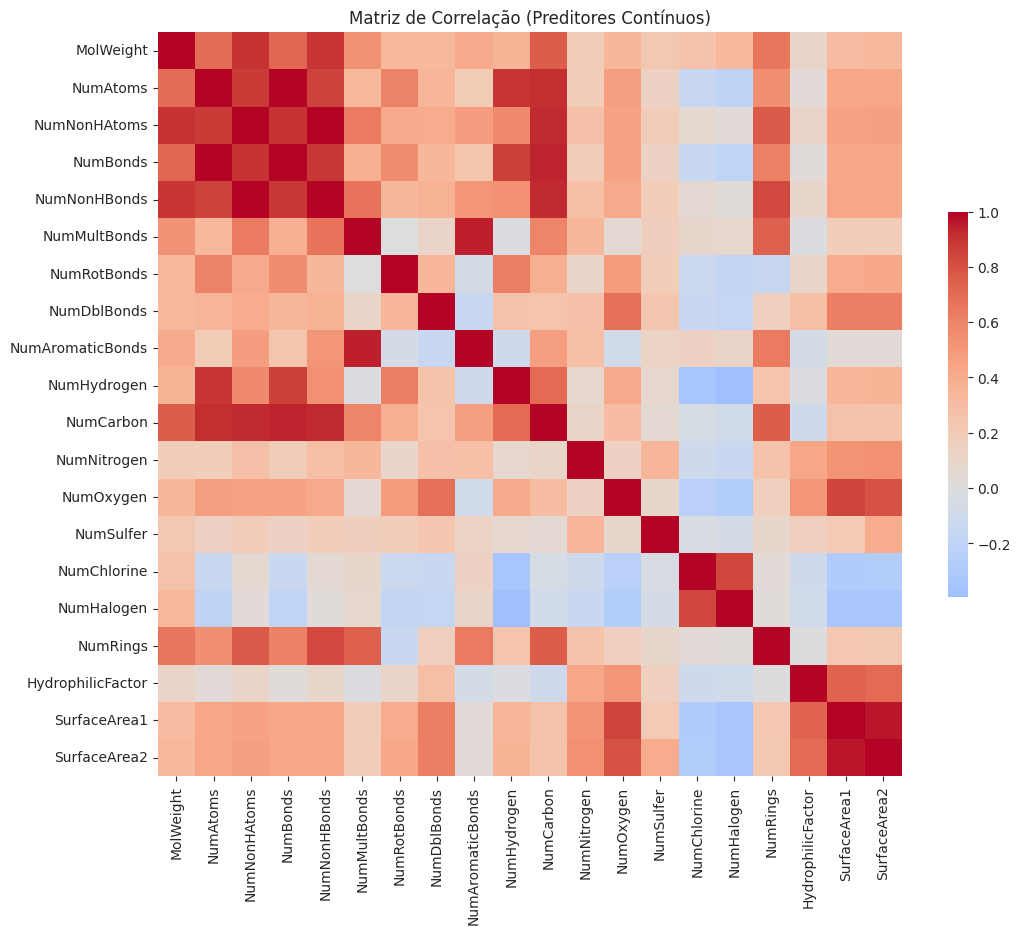


Top 5 Correlações Positivas com Solubilidade:
HydrophilicFactor    0.365138
FP072                0.336640
FP015                0.332292
SurfaceArea1         0.311711
SurfaceArea2         0.274385
dtype: float64

Top 5 Correlações Negativas com Solubilidade:
FP076          -0.537737
NumNonHAtoms   -0.583231
NumNonHBonds   -0.585493
NumCarbon      -0.606792
MolWeight      -0.658528
dtype: float64


In [39]:
# =============================================================================
# EDA: CORRELAÇÕES
# =============================================================================
print("\n>>> ANÁLISE DE CORRELAÇÕES (Parte 0)...")

# 1. Matriz de Correlação entre Preditores

# Nesse caso, pegamos só as contínuas para não deixar o mapa de calor muito grande
corr_matrix = X_train_trans[cols_continuas].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, cbar_kws={"shrink": .5})
plt.title("Matriz de Correlação (Preditores Contínuos)")
plt.show()

# 2. Correlação Linear Individual (Preditores vs Outcome)
y_train_series = pd.Series(y_train, index=X_train_trans.index)

correlations_y = X_train_trans.corrwith(y_train_series).sort_values(ascending=False)


print("\nTop 5 Correlações Positivas com Solubilidade:")
print(correlations_y.head(5))
print("\nTop 5 Correlações Negativas com Solubilidade:")
print(correlations_y.tail(5))



>>> GERANDO SCATTER PLOTS (Predictor vs Outcome)


/home/natan/Área de trabalho/HW2/venv/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


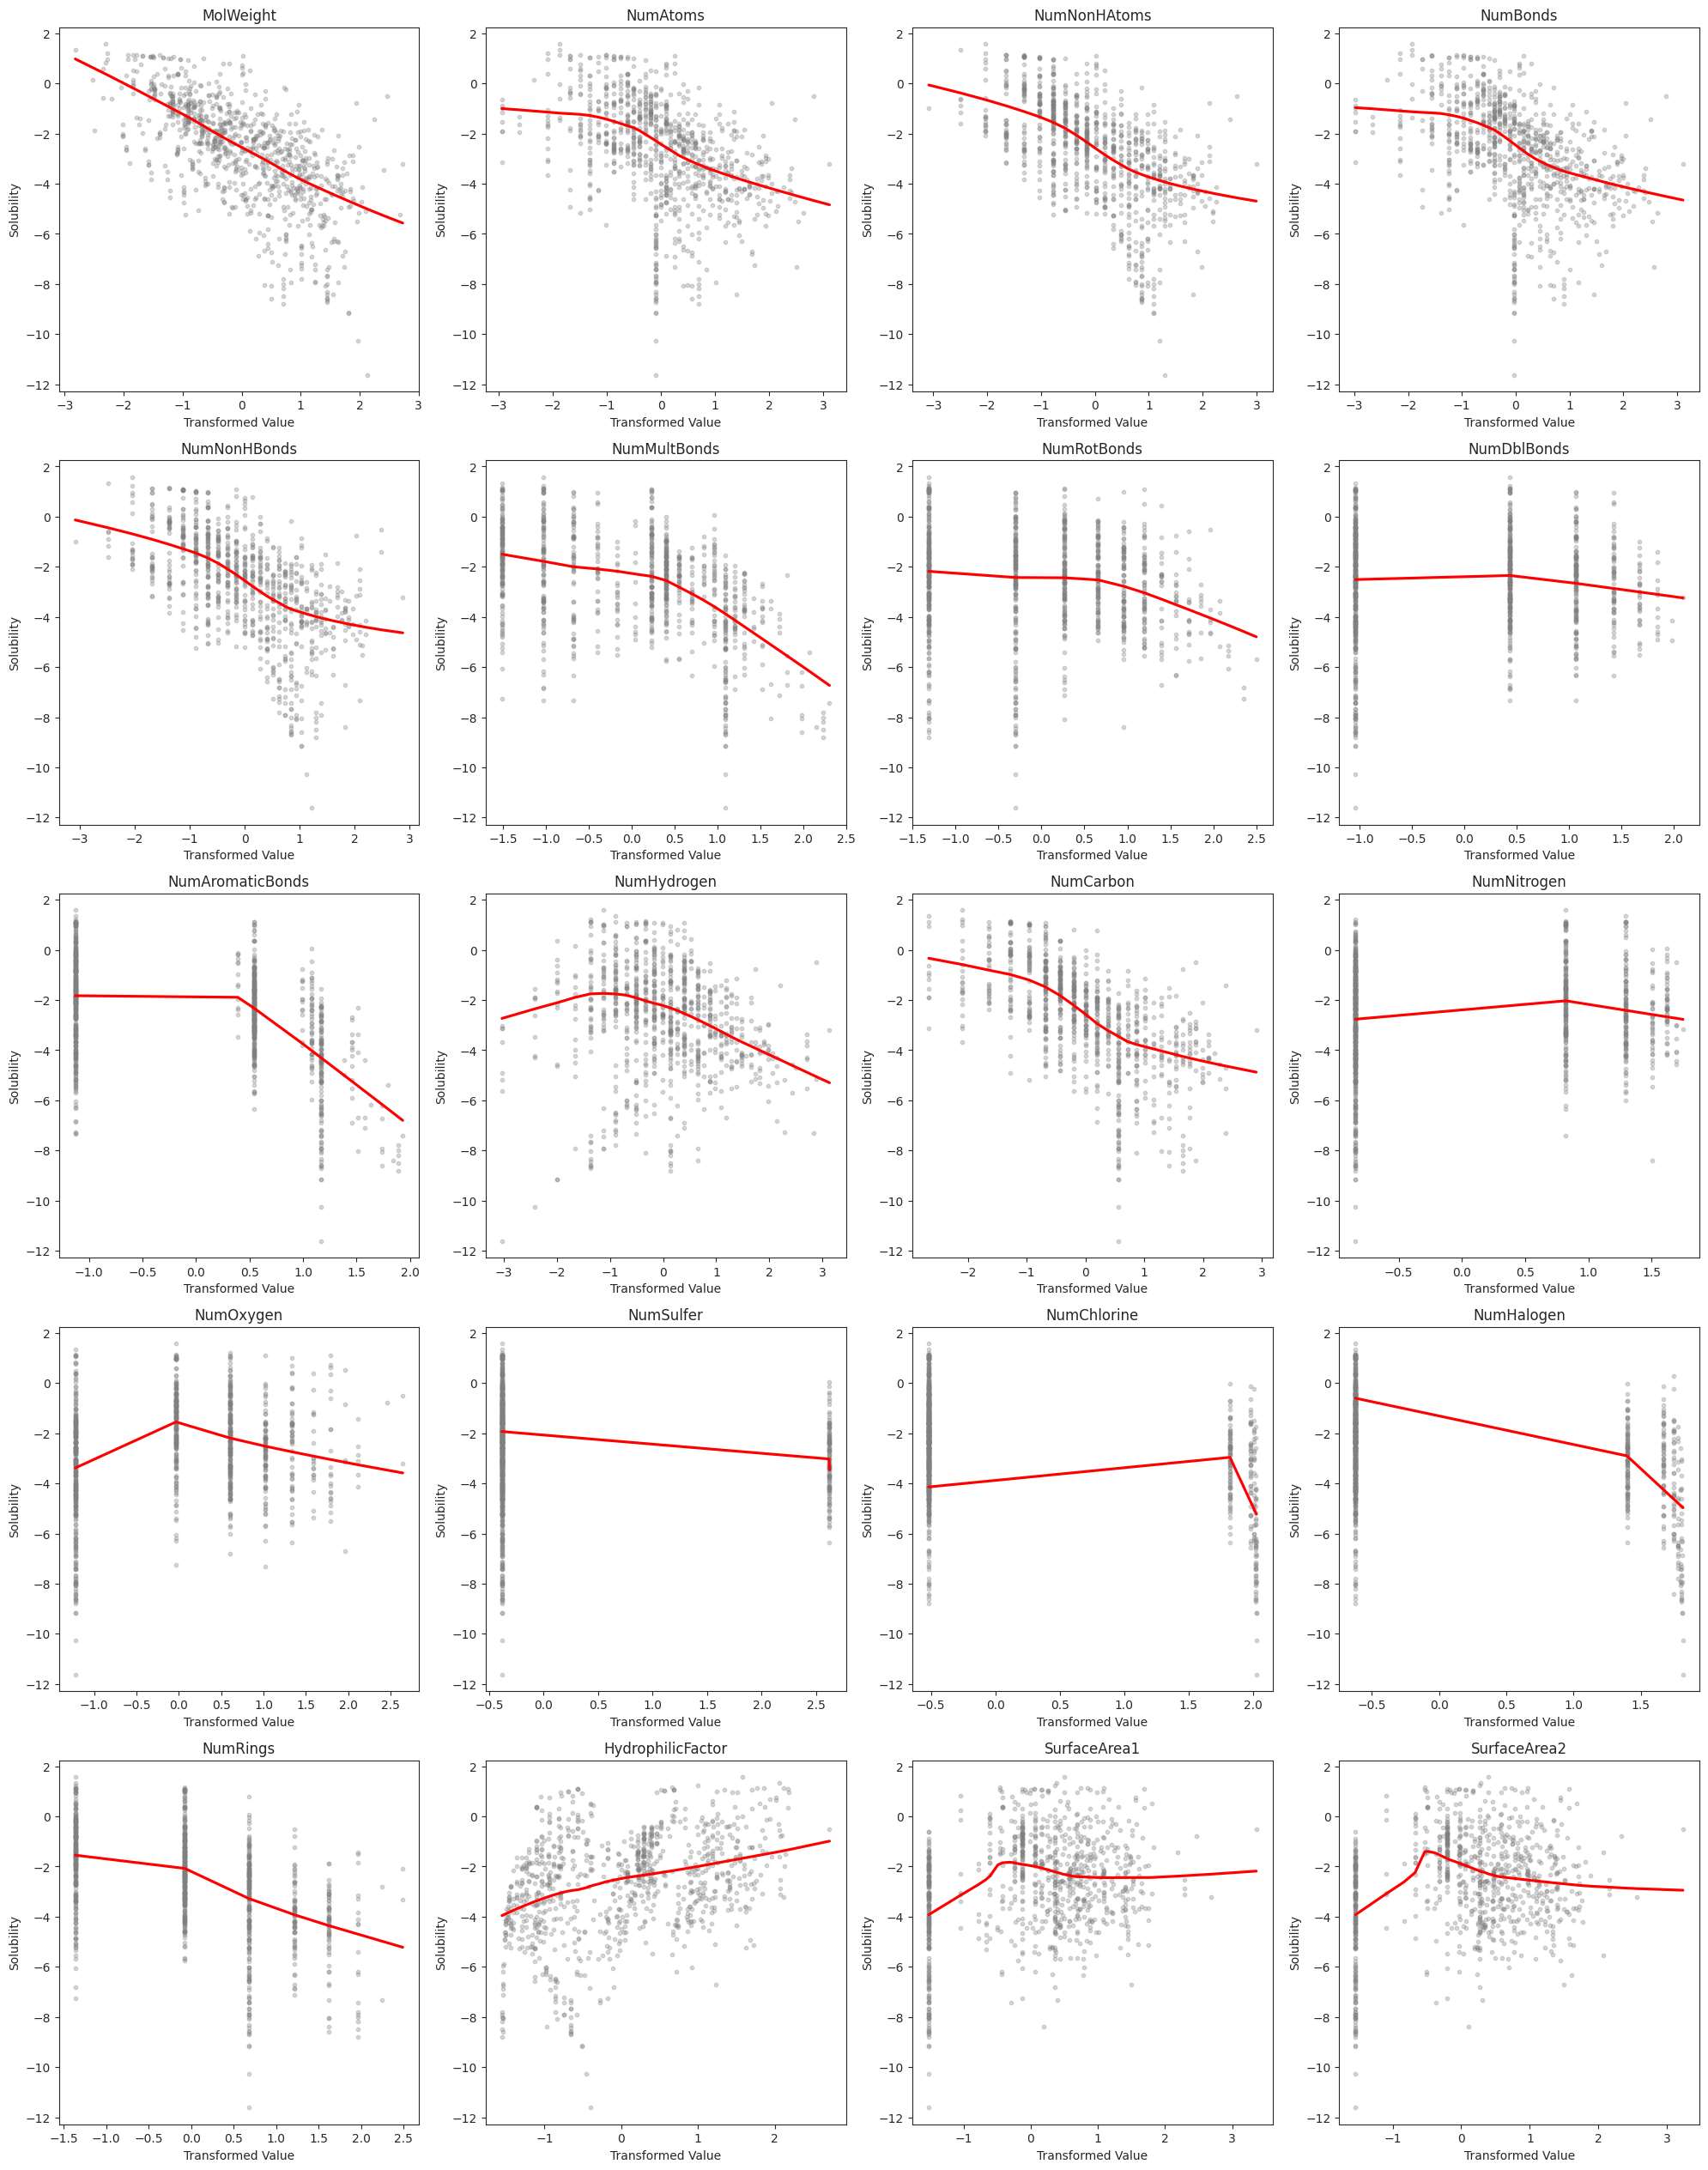

Comentário: Observe se a linha vermelha é reta (linear) ou curva (não-linear).


In [40]:
# =============================================================================
# VISUALIZAÇÃO DE LINEARIDADE (FIGURA 6.3 do Livro)
# =============================================================================
print("\n>>> GERANDO SCATTER PLOTS (Predictor vs Outcome)")

# Vamos pegar as variáveis contínuas transformadas

num_vars = len(cols_continuas)
# Configura o grid de subplots (ajuste colunas conforme necessário)
cols = 4
rows = (num_vars // cols) + 1

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
axes = axes.flatten()

for i, col in enumerate(cols_continuas):
    # Plot scatter com linha de suavização (lowess)
    # scatter_kws diminui o tamanho das bolinhas para ficar legível
    sns.regplot(x=X_train_trans[col], y=y_train, ax=axes[i],
                lowess=True, # Isso faz a linha curva suave (não linear)
                scatter_kws={'alpha': 0.3, 's': 10, 'color': 'gray'},
                line_kws={'color': 'red'})
    axes[i].set_title(col)
    axes[i].set_xlabel("Transformed Value")
    axes[i].set_ylabel("Solubility")

# Remove eixos vazios se houver
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
print("Comentário: Observe se a linha vermelha é reta (linear) ou curva (não-linear).")


>>> GERANDO SCREE PLOT (PCA)...
Variância explicada pelo 1º Componente: 12.42%


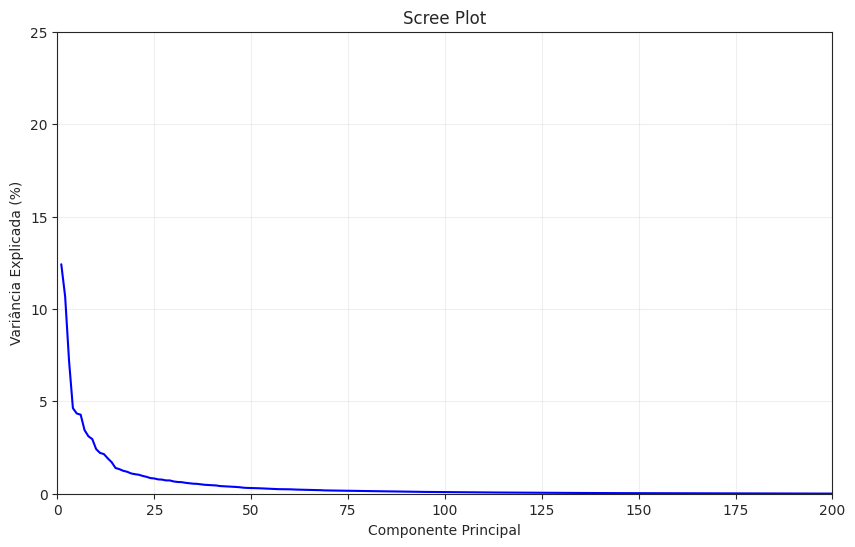

In [41]:
# =============================================================================
# 3.4. DIAGNÓSTICO DE VARIÂNCIA VIA PCA - SCREE PLOT
# =============================================================================
print("\n>>> GERANDO SCREE PLOT (PCA)...")

# Para a visualização da PCA (e apenas para ela), precisamos
# colocar TUDO na mesma escala para fazer o gráfico
# Isso não afeta os dados X_train_trans usados na regressão depois.

# 1. Cria uma cópia temporária para não estragar o dataset principal
X_pca_temp = X_train_trans.copy()

# 2. Padroniza TUDO (Binárias + Contínuas) apenas para o PCA
scaler_global = StandardScaler()
X_pca_scaled = scaler_global.fit_transform(X_pca_temp)

# 3. Roda o PCA
pca = PCA()
pca.fit(X_pca_scaled)

# 4. Plota
explained_var = pca.explained_variance_ratio_ * 100
components = np.arange(1, len(explained_var) + 1)

print(f"Variância explicada pelo 1º Componente: {explained_var[0]:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(components, explained_var, 'b-', linewidth=1.5)
plt.title("Scree Plot")
plt.xlabel("Componente Principal")
plt.ylabel("Variância Explicada (%)")
plt.xlim(0, 200)
plt.ylim(0, 25)
plt.grid(True, alpha=0.3)
plt.show()

In [42]:
# =============================================================================
# FILTRAGEM DE PREDIRORES (Alta Colinearidade)
# =============================================================================
# Necessário para evitar instabilidade na inversão de matriz do OLS Manual
print("\n>>> REMOVENDO ALTA CORRELAÇÃO (>0.9)...")

def identificar_correlacoes(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return to_drop

cols_drop = identificar_correlacoes(X_train_trans, 0.9)
X_train_filtered = X_train_trans.drop(columns=cols_drop)
X_test_filtered = X_test_trans.drop(columns=cols_drop)

print(f"Preditores iniciais: {X_train_trans.shape[1]}")
print(f"Preditores removidos: {len(cols_drop)}")
print(f"Preditores finais: {X_train_filtered.shape[1]}")



>>> REMOVENDO ALTA CORRELAÇÃO (>0.9)...
Preditores iniciais: 228
Preditores removidos: 36
Preditores finais: 192


In [43]:
# =============================================================================
# OLS: IMPLEMENTAÇÃO MANUAL VS FUNÇÃO PRONTA
# =============================================================================
print("\n>>> OLS: IMPLEMENTAÇÃO MANUAL vs SCIKIT-LEARN...")

# --- A) Built-in (Scikit-Learn) ---
ols_sklearn = LinearRegression()
ols_sklearn.fit(X_train_filtered, y_train)
y_pred_sklearn = ols_sklearn.predict(X_test_filtered)

rmse_sk = np.sqrt(mean_squared_error(y_test, y_pred_sklearn))
r2_sk = r2_score(y_test, y_pred_sklearn)

# --- B) From Scratch (Álgebra Linear) ---
# Fórmula: Beta = (X^T * X)^-1 * X^T * y
# Precisamos adicionar uma coluna de 1s para o intercepto (bias)

# Adiciona coluna de 1s no inicio
X_train_mat = np.c_[np.ones(len(X_train_filtered)), X_train_filtered.values]
X_test_mat = np.c_[np.ones(len(X_test_filtered)), X_test_filtered.values]
y_train_vec = y_train

# Cálculo dos Coeficientes (Betas)
# Nota: Usamos pinv (pseudo-inversa) para estabilidade, mas inv funciona se não for singular
beta_hat = np.linalg.pinv(X_train_mat.T @ X_train_mat) @ X_train_mat.T @ y_train_vec

# Predição: y_hat = X_new * beta
y_pred_scratch = X_test_mat @ beta_hat

# Cálculo Métricas Manuais
residuals = y_test - y_pred_scratch
mse_scratch = np.mean(residuals**2)
rmse_scratch = np.sqrt(mse_scratch)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_test - np.mean(y_test))**2)
r2_scratch = 1 - (ss_res / ss_tot)

print("-" * 50)
print(f"{'Métrica':<15} | {'Scikit-Learn':<15} | {'Manual (Scratch)':<15}")
print("-" * 50)
print(f"{'RMSE Teste':<15} | {rmse_sk:<15.5f} | {rmse_scratch:<15.5f}")
print(f"{'R2 Teste':<15} | {r2_sk:<15.5f} | {r2_scratch:<15.5f}")
print("-" * 50)


>>> OLS: IMPLEMENTAÇÃO MANUAL vs SCIKIT-LEARN...
--------------------------------------------------
Métrica         | Scikit-Learn    | Manual (Scratch)
--------------------------------------------------
RMSE Teste      | 0.74048         | 0.74048        
R2 Teste        | 0.87268         | 0.87268        
--------------------------------------------------


In [44]:
# =============================================================================
# 6. CROSS-VALIDATION: MANUAL VS FUNÇÃO PRONTA
# =============================================================================
print("\n>>> CROSS-VALIDATION (10-FOLD): MANUAL vs BUILT-IN...")

K = 10

# --- A) Built-in (Scikit-Learn) ---
kfold = KFold(n_splits=K, shuffle=True, random_state=100)
# o sklearn usa MSE negativo, por isso o sinal de menos vem antes
scores_mse = cross_val_score(ols_sklearn, X_train_filtered, y_train, cv=kfold, scoring='neg_mean_squared_error')
scores_r2 = cross_val_score(ols_sklearn, X_train_filtered, y_train, cv=kfold, scoring='r2')

cv_rmse_sk = np.sqrt(-scores_mse.mean())
cv_r2_sk = scores_r2.mean()

# --- B) From Scratch (Loop Manual) ---
# Vamos embaralhar os índices
indices = np.arange(len(X_train_filtered))
np.random.seed(100) # Mesmo seed para tentar aproximar
np.random.shuffle(indices)

# Dividir em K folds
folds = np.array_split(indices, K)

rmse_list_manual = []
r2_list_manual = []

for i in range(K):
    # Separa índices de teste (validação) e treino
    test_idx = folds[i]
    # O resto é treino
    train_idx = np.concatenate(folds[:i] + folds[i+1:])

    # Separa dados
    X_f_train = X_train_filtered.iloc[train_idx]
    y_f_train = y_train[train_idx]
    X_f_val = X_train_filtered.iloc[test_idx]
    y_f_val = y_train[test_idx]

    # Treina modelo (podemos usar a classe pronta aqui para focar na lógica do CV)
    model_cv = LinearRegression()
    model_cv.fit(X_f_train, y_f_train)

    # Prediz
    preds_val = model_cv.predict(X_f_val)

    # Calcula métricas do fold
    fold_rmse = np.sqrt(mean_squared_error(y_f_val, preds_val))
    fold_r2 = r2_score(y_f_val, preds_val)

    rmse_list_manual.append(fold_rmse)
    r2_list_manual.append(fold_r2)

cv_rmse_manual = np.mean(rmse_list_manual)
cv_r2_manual = np.mean(r2_list_manual)

print("-" * 50)
print(f"{'CV Métrica':<15} | {'Scikit-Learn':<15} | {'Manual (Scratch)':<15}")
print("-" * 50)
print(f"{'CV RMSE':<15} | {cv_rmse_sk:<15.5f} | {cv_rmse_manual:<15.5f}")
print(f"{'CV R2':<15} | {cv_r2_sk:<15.5f} | {cv_r2_manual:<15.5f}")
print("-" * 50)



>>> CROSS-VALIDATION (10-FOLD): MANUAL vs BUILT-IN...
--------------------------------------------------
CV Métrica      | Scikit-Learn    | Manual (Scratch)
--------------------------------------------------
CV RMSE         | 0.72274         | 0.71883        
CV R2           | 0.86857         | 0.86857        
--------------------------------------------------


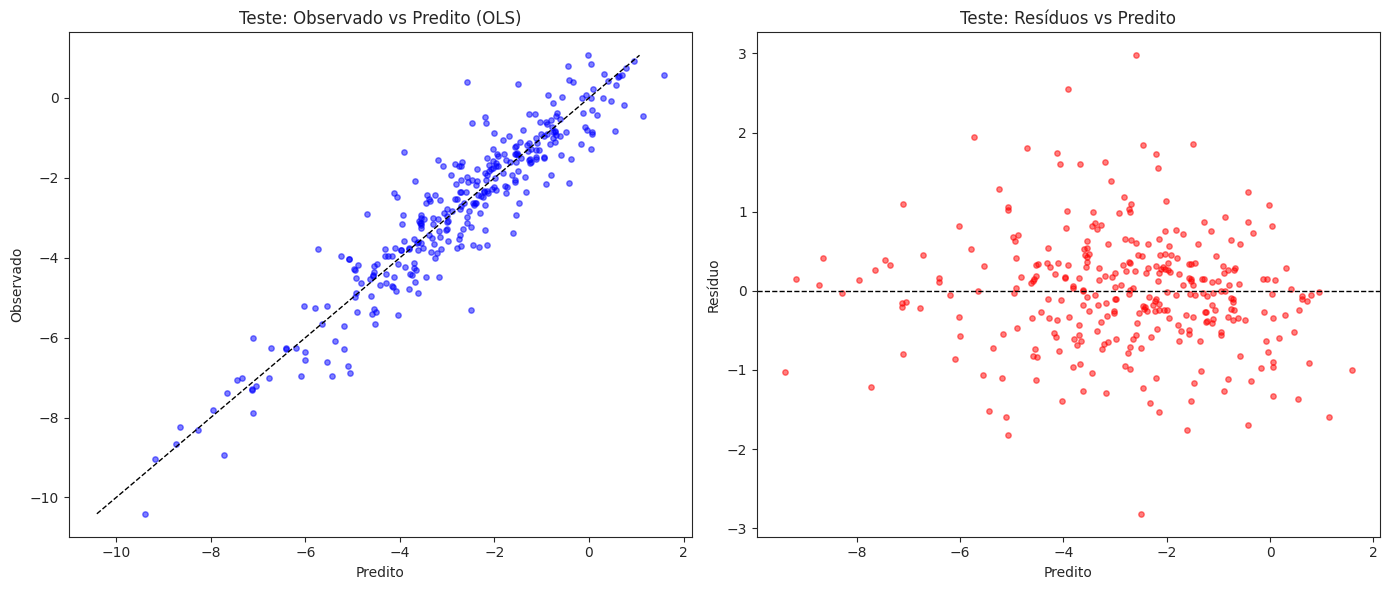

In [45]:
# =============================================================================
# 7. DIAGNÓSTICOS FINAIS (Gráficos)
# =============================================================================
# Usando o modelo Built-in já treinado para gerar os gráficos finais
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico 1: Observado vs Predito
ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax[0].scatter(y_pred_sklearn, y_test, alpha=0.5, color='blue', s=15)
ax[0].set_title("Teste: Observado vs Predito (OLS)")
ax[0].set_xlabel("Predito")
ax[0].set_ylabel("Observado")

# Gráfico 2: Resíduos vs Predito
residuos = y_test - y_pred_sklearn
ax[1].axhline(y=0, color='black', linestyle='--', lw=1)
ax[1].scatter(y_pred_sklearn, residuos, alpha=0.5, color='red', s=15)
ax[1].set_title("Teste: Resíduos vs Predito")
ax[1].set_xlabel("Predito")
ax[1].set_ylabel("Resíduo")

plt.tight_layout()
plt.show()


In [46]:
import pickle

with open("dados_preprocessados.pkl", "wb") as f:
    pickle.dump(
        (X_train_filtered, X_test_filtered, y_train, y_test),
        f
    )

print("Dados pré-processados salvos com sucesso!")


Dados pré-processados salvos com sucesso!
